# Regression Analysis on Evictions, Poverty, and Race
In the "enhancing-statistical-rigor" notebook it became clear that the EL mislabeled the flag columns:
- imputed -- was accidentally labeled --> low-flag
- subbed -- was accidentally labeled --> imputed
- low-flag -- was accidentally labeled --> subbed.

So, I'll fix the labels and then compare regression analyses on:
- all the data
- filtered data (i.e. drop the data points that have been flagged as low)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import cufflinks as cf # cufflinks binds plotly to pandas dataframes in IPython notebook.
import plotly.graph_objs as go
from plotly import tools

In [2]:
import plotly.figure_factory as ff

In [3]:
sns.set(style = 'darkgrid')

## - Read in the County Level Data and correct the labels

In [4]:
counties_evicts_df = pd.read_csv('data/counties.csv')
counties_evicts_df.rename(columns = {'low-flag': 'imputed',
                                    'imputed': 'subbed',
                                    'subbed': 'low-flag'}, inplace = True)
counties_evicts_df.head()

,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,median-household-income,median-property-value,...,pct-multiple,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,imputed,subbed,low-flag
0,47001,2000,Anderson County,Tennessee,71330.0,13.14,27.49,450.0,35483.0,87500.0,...,1.14,0.07,8189.0,125.0,118.0,1.44,1.53,0,0,1
1,47003,2000,Bedford County,Tennessee,37586.0,13.14,26.46,488.0,36729.0,79000.0,...,0.77,0.05,3679.0,104.0,98.0,2.66,2.83,0,0,0
2,47005,2000,Benton County,Tennessee,16537.0,15.63,19.47,367.0,28679.0,67000.0,...,0.62,0.03,1336.0,17.0,17.0,1.27,1.27,0,0,0
3,47007,2000,Bledsoe County,Tennessee,12367.0,18.07,18.24,343.0,28982.0,67200.0,...,1.03,0.02,808.0,0.0,0.0,0.00,0.00,0,0,0
4,47009,2000,Blount County,Tennessee,105823.0,9.73,24.11,450.0,37862.0,103900.0,...,0.88,0.05,10286.0,210.0,201.0,1.95,2.04,0,0,1


Confirm my 'low-flag' column corroborates the criteria stated in pg. 40 of the methodology report
- *i.e. that at least 25% of the counties between 2009 - 2016 are flagged as low*
    - that's from January 1st 2009 - January 1st 2016

In [5]:
cty_09_15_index = [year in range(2009, 2016) for year in counties_evicts_df.year]
print('LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:') 
print("---------------------------------")
print('Years in range(2009, 2016)=', list(range(2009, 2016)))
print("")
print('Fraction of TN counties labeled as low:', counties_evicts_df[cty_09_15_index]['low-flag'].sum()/len(counties_evicts_df[cty_09_15_index]))
      

LEFT-INCLUSIVE, RIGHT-EXCLUSIVE:
---------------------------------
Years in range(2009, 2016)= [2009, 2010, 2011, 2012, 2013, 2014, 2015]

Fraction of TN counties labeled as low: 0.24661654135338346


## - Pre-process the data for visualization and regression analysis
- pivot the counties for time series analysis

In [6]:
pivoted_counties = counties_evicts_df.pivot(index = 'year', columns = 'name', values= 'poverty-rate')
pivoted_counties.head()

name,Anderson County,Bedford County,Benton County,Bledsoe County,Blount County,Bradley County,Campbell County,Cannon County,Carroll County,Carter County,...,Unicoi County,Union County,Van Buren County,Warren County,Washington County,Wayne County,Weakley County,White County,Williamson County,Wilson County
year,,,,,,,,,,,,,,,,,,,,,
2000,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2001,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2002,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2003,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66
2004,13.14,13.14,15.63,18.07,9.73,12.22,22.83,12.77,13.89,16.85,...,13.05,19.62,15.24,16.59,13.95,16.3,16.04,14.26,4.72,6.66


In [7]:
layout = go.Layout(
    autosize = True,
    #rangeslider = True,
    #width = 1600, 
    height = 800)

pivoted_counties.iplot(filename='pivoted-tn-county-poverty-timeseries', sharing = 'public',
                       #layout = layout,
                       width = 1, dash = 'line', mode = 'lines',
                      title = 'TN County Poverty Rate, 2000 - 2016', yTitle = 'Poverty %', xTitle = 'Year'
                      #rangeslider = True, 
                       )

## - Visualizing flagged data in the eviction rate time series for all counties
can recycle this routine for other variable time-series

In [8]:
pvt_cnty_evic_rates = counties_evicts_df.pivot(index = 'year', columns = 'name', values= ['eviction-rate', 'low-flag'])

In [9]:
pvt_cnty_evic_rates.head(2)


eviction-rate                                              \
name Anderson County Bedford County Benton County Bledsoe County   
year                                                               
2000            1.44           2.66          1.27            0.0   
2001            2.02           2.89          2.21            0.0   

                                                                 \
name Blount County Bradley County Campbell County Cannon County   
year                                                              
2000          1.95            NaN            1.75          0.47   
2001          2.37           2.12            1.94          0.09   

                                       ...           low-flag               \
name Carroll County Carter County      ...      Unicoi County Union County   
year                                   ...                                   
2000           1.13           NaN      ...                1.0          0.0   
2001           1.19          2.38      ...                0.0          0.0   

                                                                    \
name Van Buren County Warren County Washington County Wayne County   
year                                                                 
2000              0.0           0.0               0.0          1.0   
2001              0.0           0.0               1.0          0.0   

                                                                  
name Weakley County White County Williamson County Wilson County  
year                                                              
2000            0.0          0.0               1.0           0.0  
2001            0.0          0.0               1.0           0.0  

[2 rows x 190 columns]

In [10]:
def mutate_traces_by_flag(df):
    '''Takes a timeseries df with two column levels and
    splits columns in one level according to values in the second level.
    It transfers the values from the first level to the second level; overwriting the second level.
    Returns the mutated df (with two levels)'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    dfo = df.copy(deep = True)
    # for each col in lv0
    for col in dfo[lv0].columns:
        # for each year in that column
        for year in dfo.index:
            # if variable is flagged
            if dfo[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[lv1][col][year] = dfo[lv0][col][year]
                # replace that value with None
                dfo[lv0][col][year] = None
            else:
                dfo[lv1][col][year] == None
                
    return dfo

In [11]:
def split_trace_by_flag(df, verbose = False):
    '''Takes a timeseries df with two column levels and 
    splits each column from first level into two columns according to whether or not 
    that cell has been flagged in the other level.
    Returns a one level df with twice as many columns'''
    if len(df.columns.levels[0]) != 2:
        print('Need df with two levels of columns. Received df.columns.levels[0] = ',
             df.columns.levels[0])
        assert df.columns.levels[0] == 2
    # store level 1 and 2
    lv0 = df.columns.levels[0][0]
    lv1 = df.columns.levels[0][1]
    
    # initialize copy of df to work on
    dfo = df[lv0].copy(deep = True)
    
    # for each col in dfo
    for col in dfo.columns:
        # initialize a flag column
        fcol = str(col)+' flagged'
        if verbose:
            print(fcol)
        dfo[fcol] = None
        # for each year in that column
        for year in dfo.index:
            if verbose:
                print(year)
            # if variable is flagged
            if df[lv1][col][year] == 1:
                # paste the flagged value into the flag col
                dfo[fcol][year] = df[lv0][col][year]
                # replace that value with None
                #dfo[col][year] = None
                
    return dfo

In [12]:
split_cnty_evic_rates = split_trace_by_flag(pvt_cnty_evic_rates)

In [13]:
split_cnty_evic_rates.sort_index(axis = 1, inplace=True)

In [14]:
split_cnty_evic_rates.head(2)

name,Anderson County,Anderson County flagged,Bedford County,Bedford County flagged,Benton County,Benton County flagged,Bledsoe County,Bledsoe County flagged,Blount County,Blount County flagged,...,Wayne County,Wayne County flagged,Weakley County,Weakley County flagged,White County,White County flagged,Williamson County,Williamson County flagged,Wilson County,Wilson County flagged
year,,,,,,,,,,,,,,,,,,,,,
2000,1.44,1.44,2.66,None,1.27,None,0.0,None,1.95,1.95,...,0.29,0.29,1.40,None,NaN,None,1.65,1.65,2.61,None
2001,2.02,2.02,2.89,None,2.21,None,0.0,None,2.37,2.37,...,0.87,None,1.52,None,NaN,None,1.53,1.53,2.95,None


In [15]:
split_cnty_evic_rates.iplot(filename='pivoted-tn-county-eviction-rate-timeseries', sharing = 'public',
                       #width = 1, dash = 'line', mode = 'lines',
                          mode = 'marker',
                            
                      title = 'TN Counties Eviction Rates, 2000 - 2016', yTitle = '%', xTitle = 'Year',
                      rangeslider = False, 
                       )

Let's try to just add a trace of red markers over the flagged values

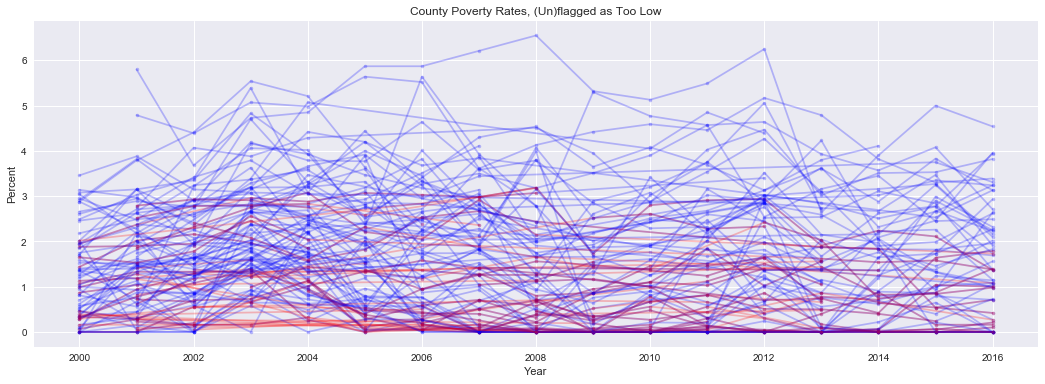

In [16]:
for col in split_cnty_evic_rates:
    if 'flagged' not in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'blue', alpha = .25, marker = '.')
        except:
            continue
    if 'flagged' in col:
        try:
            split_cnty_evic_rates[col].dropna().plot(figsize = (18, 6), color = 'red', alpha = .25, marker = '.')
        except:
            continue

#plt.figure(figsize=(18, 6))
plt.title('County Poverty Rates, (Un)flagged as Too Low')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.show()

To achieve this in Plotly I'll have to make two traces for every county, then I'll have to plot all 190 ish traces specifying the color of each trace. 

pseudo-code:

initialize 190ish variables

for each county assign a scatter graph object to it's two corresponding variables
append the trace to the data to be ploted by plotly. 

## - Compare flagged and unflagged eviction data

In [18]:
poverty_trace = go.Box(
    y = counties_evicts_df['poverty-rate'],
    x = counties_evicts_df.year,
    name = 'TN Poverty Rates',
    opacity = 0.25,
    marker = dict(color = 'black', opacity = 0.25, symbol = 'square')
)
bonafide_eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0],
    name = 'TN Bonafide Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'red', opacity = 0.5, symbol = 'square')
)
flagged_poverty_trace = go.Box(
    y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
    x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 1],
    name = 'TN Low-Flagged Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'pink', opacity = 0.5, symbol = 'square')
)

eviction_trace = go.Box(
    y = counties_evicts_df['eviction-rate'],
    x = counties_evicts_df.year,
    name = 'TN Eviction Rates',
    opacity = 0.5,
    marker = dict(color = 'blue', opacity = 0.5, symbol = 'square')
)

data = [poverty_trace, eviction_trace, flagged_poverty_trace, bonafide_eviction_trace]

layout = go.Layout(
    title = 'TN Poveryt, Eviction, & Filing Rates (Boxplot Timeseries)',
    yaxis = dict(title = 'Percent'),
    xaxis = dict(title = 'Year'),
    boxmode = 'group'
)
fig = go.Figure(data = data, layout = layout)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

It's clear that once we filter out the rows that have been flagged as low we have a significant increase in the "center" of our distributions. 
- the median on the filtered data looks to be about .5% higher

Unfortunately the boxplot is actually obscuring how dense the distribution of values is. Let's try it again with some violin plots.

In [20]:
fig = ff.create_violin(counties_evicts_df.dropna(), data_header = 'eviction-rate', group_header = 'year', 
                       height = 500, width = 800)
py.iplot(fig,
        filename = 'tn-eviction-poverty-boxplot-timeseries', fileopt = 'overwrite', sharing = 'public')

⚠️ this doesn't look right. Maybe my dropna call removed entire rows instead of just cells. 
- Also it seems like I actually have a figure for every violin, which makes it akward to try and use the tools (like zooming and panning)

## - Compare regression plots of filtered and unflitered data

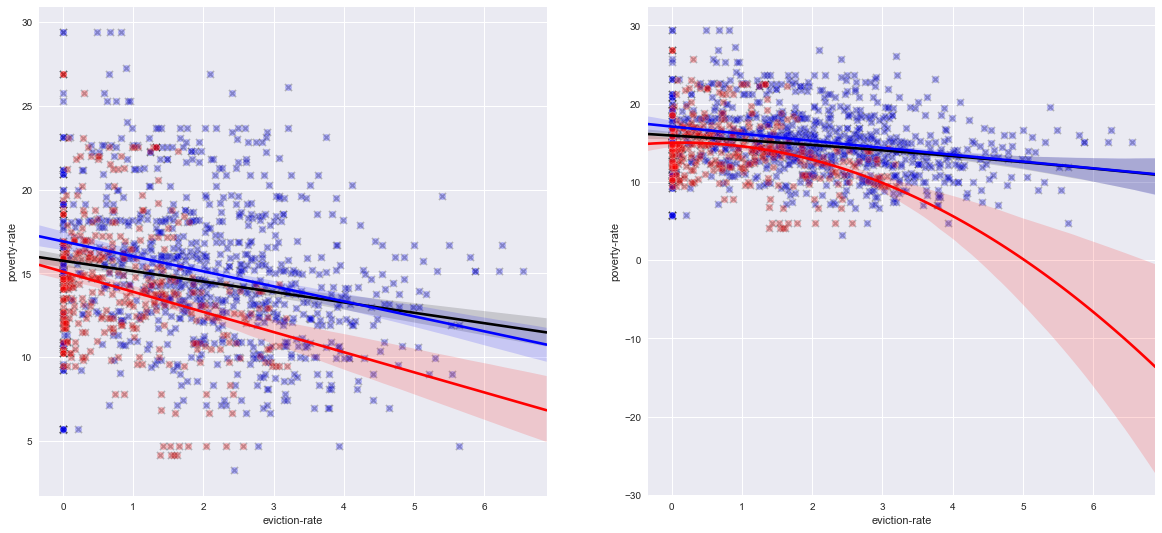

In [161]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

# add unfiltered linear regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            robust = True,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
# add filtered regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            robust = True,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)
# add low-flagged regression to axis 1
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = True,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax1)

sns.regplot(y = counties_evicts_df['poverty-rate'],
           x = counties_evicts_df['eviction-rate'],
            order = 2, robust = False,
           color = 'black', marker = 'x', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 0],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0],
            order = 2, robust = False,
           color = 'blue', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)

sns.regplot(y = counties_evicts_df['poverty-rate'][counties_evicts_df['low-flag'] == 1],
           x = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 1],
            robust = False, order = 2,
           color = 'red', marker = 'o', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'.5'},
           ax = ax2)
plt.show()

**Initial Observations:**
- the filtered data seems to display a slightly steeper slope i.e. a slightly stronger negative correlation.
- Also the confidence intervals are better for the first order liner regression

# Let's facet out this analysis by year

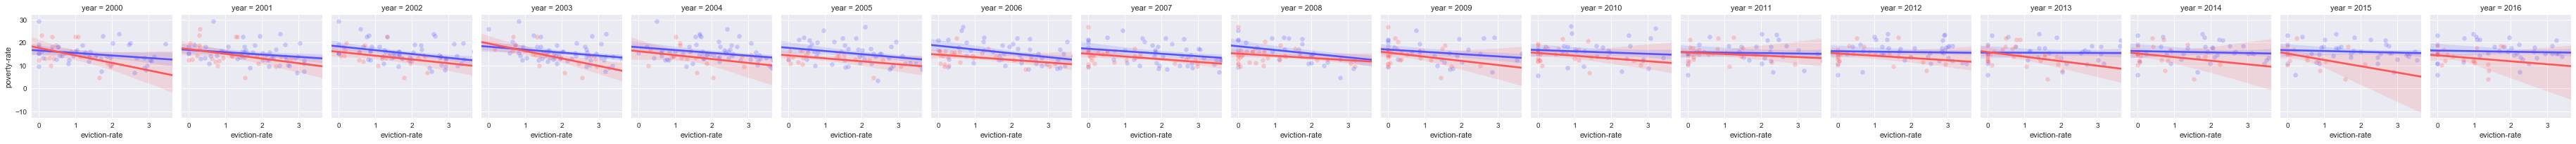

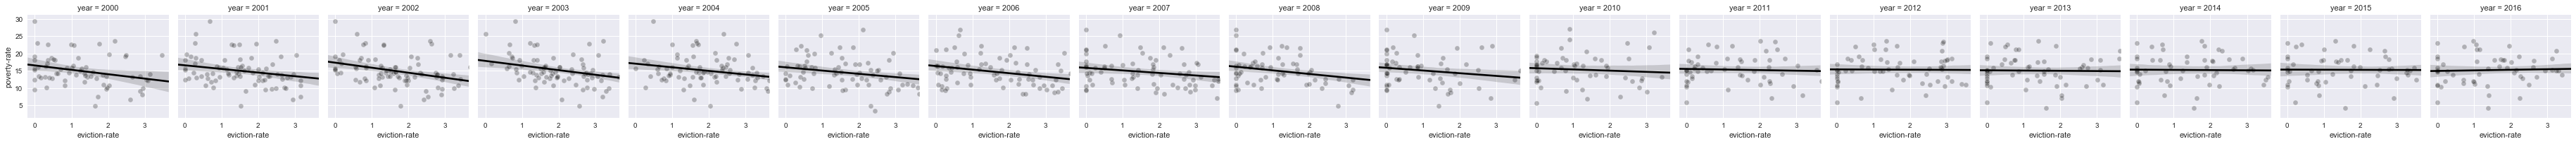

In [179]:
g = sns.FacetGrid(counties_evicts_df, col = 'year', #col_wrap = 9,
                  hue = 'low-flag', palette = 'seismic')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          #color = 'black', 
          scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

g = sns.FacetGrid(counties_evicts_df, col = 'year')
g = g.map(sns.regplot, 'eviction-rate', 'poverty-rate',
          color = 'black', scatter_kws = {'alpha':'.25', 
                                            'edgecolors':'white',
                                           'linewidths':'1'})

**Initial Observations:**
- looks like the correlation got leveled off sharply after 2009. Which is interesting. The housing crisis seems to have "broken" the relationship between evictions and poverty. 

# Compare regression plots of bonafide vs low-flagged Data

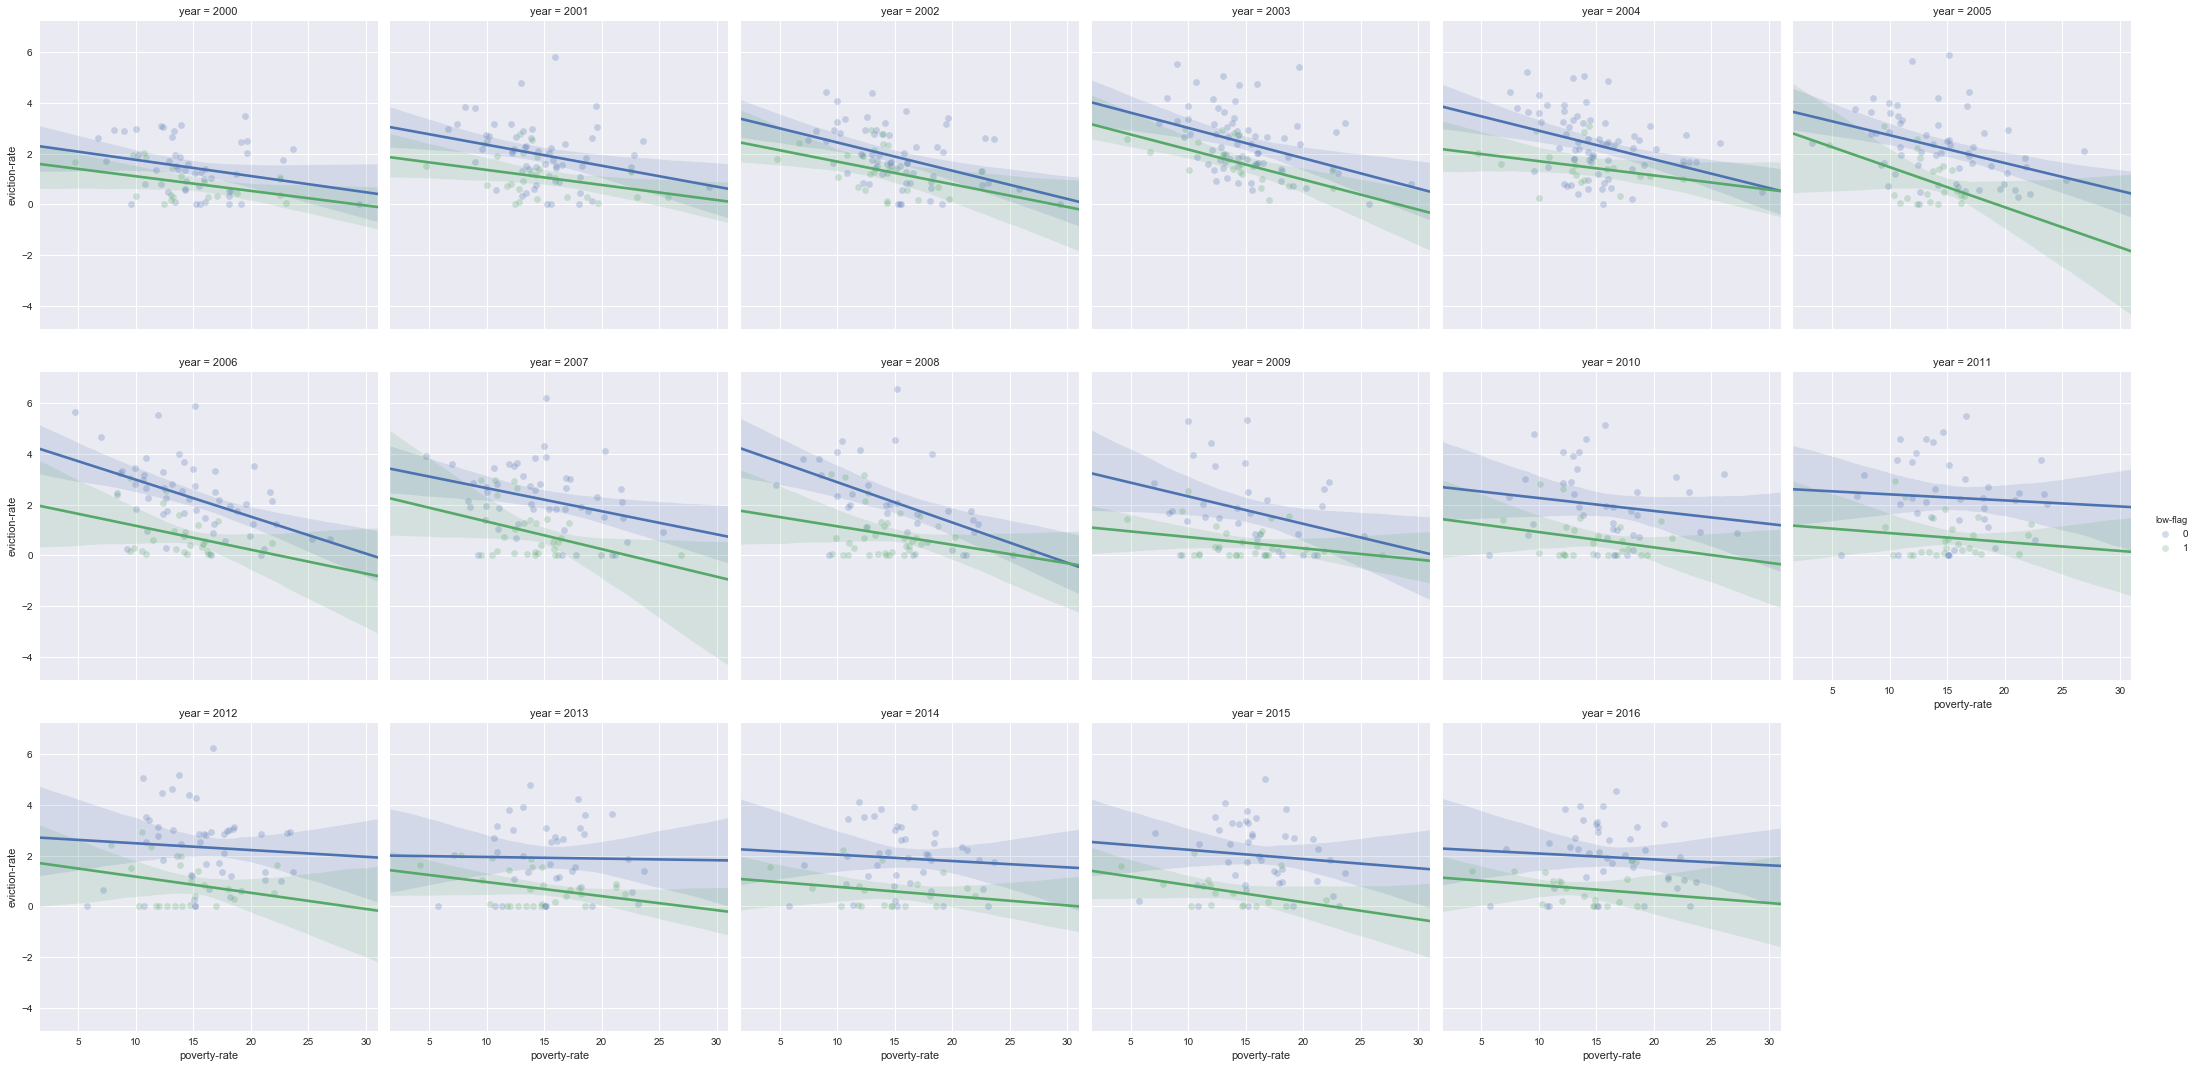

In [153]:
sns.lmplot(x = 'poverty-rate',
           y = 'eviction-rate',
           hue = 'low-flag',
           col = 'year', col_wrap = 6,
           data = counties_evicts_df,
           scatter_kws = {'alpha':'.25', 
                          'edgecolors':'white',
                          'linewidths':'.5'})
plt.show()

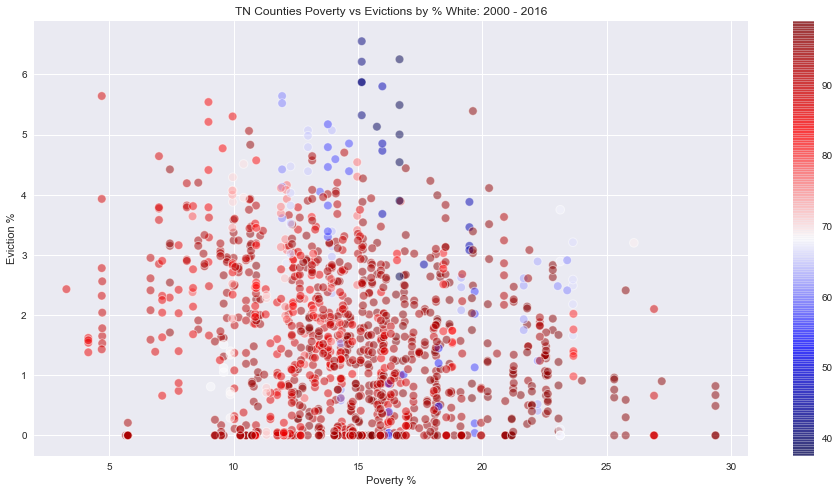

In [304]:
plt.figure(figsize=(16,8))
plt.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016')
plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
cbar = plt.colorbar()

Text(0.5,1,'TN Counties Poverty vs Evictions by % White: 2000 - 2016')

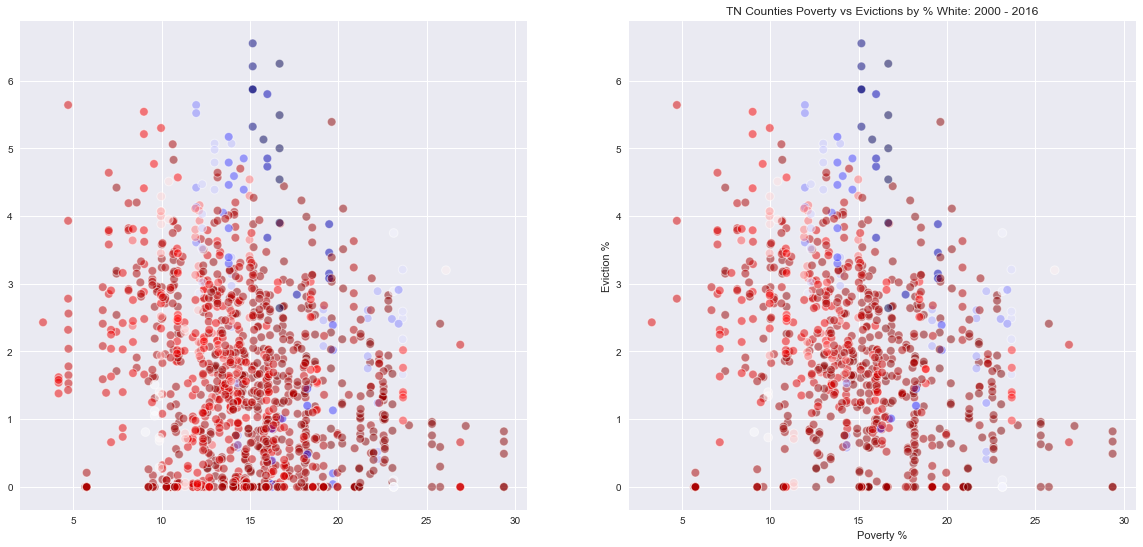

In [213]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 9))

ax1.scatter(x = 'poverty-rate', y = 'eviction-rate', data = counties_evicts_df, 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')

ax2.scatter(x = 'poverty-rate', y = 'eviction-rate', 
            data = counties_evicts_df[counties_evicts_df['low-flag'] == 0], 
            edgecolors= 'white', linewidths=1, s = 75,
            alpha = .5, c = 'pct-white', cmap = 'seismic')

plt.xlabel('Poverty %')
plt.ylabel('Eviction %')
plt.title('TN Counties Poverty vs Evictions by % White: 2000 - 2016')
#cbar = f.colorbar(mappable = c, ax=ax1)

**This is interesting, when comparing it to the unfiltered data the distribution looks significantly "thinned out." However, at first blush it seems as if we have filtered out many more "whiter" counties than "non-white" counties.**

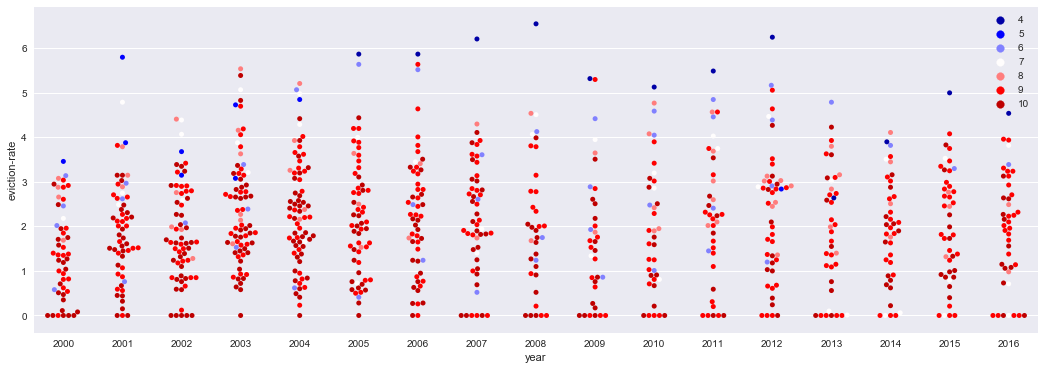

In [306]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'][counties_evicts_df['low-flag'] == 0], 
                   y = counties_evicts_df['eviction-rate'][counties_evicts_df['low-flag'] == 0], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )

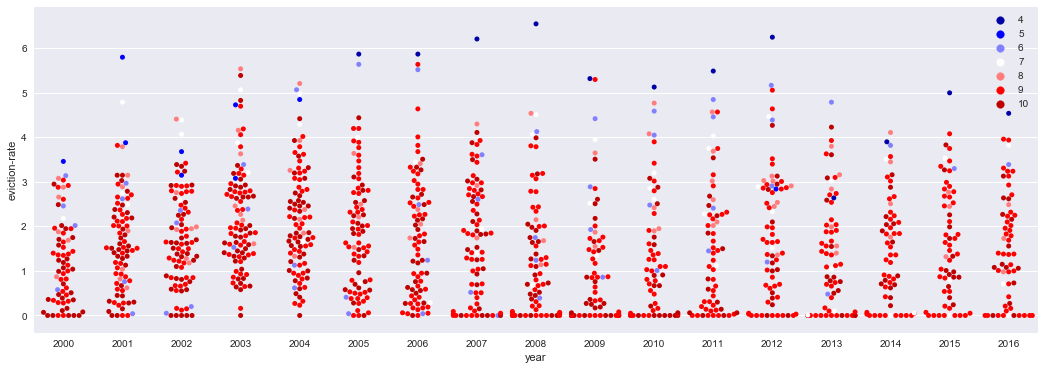

In [214]:
plt.figure(figsize=(18,6))
ax = sns.swarmplot(x = counties_evicts_df['year'], 
                   y = counties_evicts_df['eviction-rate'], 
                   hue = [round(val/10) for val in counties_evicts_df['pct-white']] , palette = 'seismic'
                  )

# Look at correlation matrix of the data
Which variables are suitable for correlation measurements?
- Do I need to adjust anything from the scales?

In [115]:
corr = counties_evicts_df[[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [215]:
#corr.head()

In [117]:
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

## Let's compare this to the correlation matrix of the filtered data
(i.e. where we drop all the rows that were flagged as having eviction data that was "too low.")

In [119]:
corr_filtered = counties_evicts_df[counties_evicts_df['low-flag'] == 0][[
    'population', 'renter-occupied-households', 'evictions', 'eviction-filings',
    'median-gross-rent', 'median-household-income', 'median-property-value',
    'poverty-rate', 'pct-renter-occupied', 'rent-burden', 
    'pct-white', 'pct-af-am', 'pct-hispanic',
    'eviction-rate', 'eviction-filing-rate'
]].corr()

In [120]:
mask_filtered = np.zeros_like(corr_filtered, dtype = np.bool)
mask_filtered[np.triu_indices_from(mask_filtered)] = True

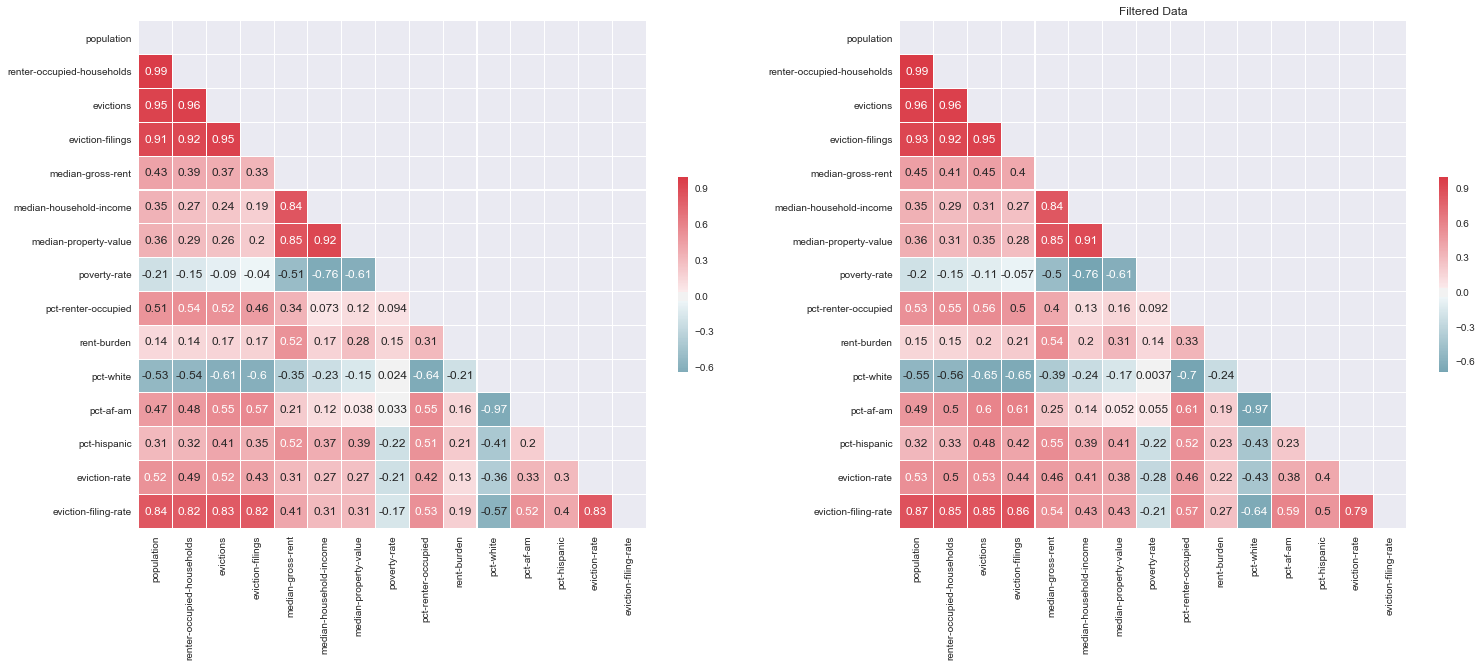

In [134]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (25,12) )

# plot the unfiltered correlation matrix heatmap
sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, cbar = True,
            robust = True,
           center = 0, square = True, linewidth = 0.1, 
            cbar_kws = {'shrink': 0.3}, 
            ax = ax1)

# plot the filtered correlation matrix heatmap
sns.heatmap(corr_filtered, mask = mask_filtered, cmap = cmap, annot = True,
           robust = True, center = 0, square = True, linewidth = 0.05,
           cbar_kws = {'shrink' : 0.3},
            ax = ax2)
plt.title('Filtered Data')
plt.show()

## That's interesting!
### poverty-rate
#### - is negatively correlated to everything except:
- 0.15, rent-burden, a weak correlation that makes sense
- 0.094, pct-renter-occupied
    - **actually, this is interesting** It suggests that whether there are or are not a lot of renters in your county does not impact whether or not there is poverty in your county. 
- **0.024, pct-white, the lowest of all the correlation coefficients** showing that a county being whiter has virtually no impact on poverty
#### - is interestingly weakly negatively correlated to:
- -0.21 eviction rate: suggesting gentrification? Or the ejection or displacement of people in poverty?
    - Where are these people ending up?
- -0.17 eviction filing rate, suggesting that pressuring 
#### - is strongly negatively (and unsurprisingly) correlated to
- measures of a countie's wealth:
    - 0.76, median-household-income
    - 0.61, median-property-value
    - 0.51, median-gross-rent